In [14]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
# mat_contents = sio.loadmat('EEG_data_KOS_1+2.mat') # or ('EEG_data.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big4CNN.mat')
mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->0.5-38Hz,Env=1.mat')


X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=False)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and minmax normalize:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
    y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
    y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
    y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
    y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test,3)
y_test = np.expand_dims(y_test,1)
y_test = y_test[:,:,:,None]
y_train = np.expand_dims(y_train,1)
y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')

leng = X.shape[2]
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (69, 60, 800, 1) Nomralized MEAN: 0.5083 min 0.0 max 1.0
train input shape (272, 60, 800, 1) Nomralized MEAN: 0.51123 min 0.0 max 1.0
test labels shape (69, 1, 800, 1) Nomralized MEAN: 0.31958 min 0.0 max 1.0
train labels shape (272, 1, 800, 1) Nomralized MEAN: 0.28003 min 0.0 max 1.0


In [21]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

# we first define the autoencoder's architecture:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.models import Model
from keras import optimizers
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

def Encoder():
    input_img = Input(shape=(60, leng, 1))  # adapt this if using `channels_first` image data format  
    
    e1 = Conv2D(4, (2, 2), activation='relu', padding='same')(input_img)
    e1b = BatchNormalization(axis=1)(e1)
    e1a = Dropout(0.1)(e1b)
    e2 = MaxPooling2D((2, 2), padding='same')(e1a)
    
    e3 = Conv2D(8, (2, 2), activation='relu', padding='same')(e2)
    e3b = BatchNormalization(axis=1)(e3)
    e3a = Dropout(0.1)(e3b)
    e4 = MaxPooling2D((3, 2), padding='same')(e3a)
    
    e5 = Conv2D(16, (2, 2), activation='relu', padding='same')(e4)
    e5b = BatchNormalization(axis=1)(e5)
    e5a = Dropout(0.2)(e5b)
    e6 = MaxPooling2D((2, 2), padding='same')(e5a)
    
    return Model(input_img, e6)

def Decoder():
    input_img = Input(shape=(5, 100, 16))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(16, (2, 2), activation='relu', padding='same')(input_img)
    d1b = BatchNormalization(axis=1)(d1)
    d1a = Dropout(0.2)(d1b)
    d2 = UpSampling2D((2, 2))(d1a)
    d3 = Conv2D(8, (3, 3), activation='relu', padding='same')(d2)
    d3b = BatchNormalization(axis=1)(d3)
    d3a = Dropout(0.3)(d3b)
    d4 = UpSampling2D((2, 2))(d3a)
    d5 = Conv2D(4, (3, 3), activation='relu', padding='same')(d4)
    d5b = BatchNormalization(axis=1)(d5)
    d5a = Dropout(0.4)(d5b)
    d6 = UpSampling2D((3, 2))(d5a)
    d7 = Conv2D(1, (3, 3), activation='relu', padding='same')(d6)
    return Model(input_img, d7)

In [22]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

In [23]:
# define input to the model:
x = Input(shape=(60, leng, 1))

# make the encoder:
enc = Model(x, Encoder()(x))
# enc.compile(optimizer='adadelta', loss='binary_crossentropy')

# make the model:
autoencoder = Model(x, Decoder()(enc(x)))

# compile the model:
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# autoencoder.compile(optimizer=sgd, loss=correlation_coefficient_loss)
autoencoder.compile(optimizer='adadelta', loss=correlation_coefficient_loss)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [24]:
# SEE INSIDE THE ENCODER AND DECODER:
Encoder().summary()
Decoder().summary()

# IN FACT, OUR AUTOENCODER WILL BE A CONCATENATION OF TWO MODELS
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 60, 800, 1)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 60, 800, 4)        20        
_________________________________________________________________
batch_normalization_37 (Batc (None, 60, 800, 4)        240       
_________________________________________________________________
dropout_37 (Dropout)         (None, 60, 800, 4)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 400, 4)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 30, 400, 8)        136       
_________________________________________________________________
batch_normalization_38 (Batc (None, 30, 400, 8)        120       
__________

Text(0.5,1,'Channels 11 in test samples 6 and 16')

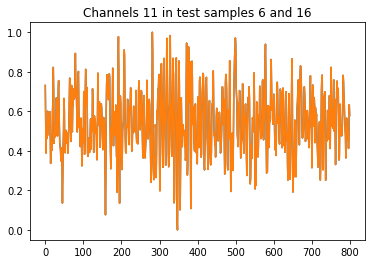

In [25]:
# inspect channel 11
%matplotlib inline
plt.plot(range(0, leng), x_test[15,10,:,0], range(0, leng), x_test[15,10,:,0])
ax = plt.gca()
ax.set_title("Channels 11 in test samples 6 and 16")

In [26]:
# Training time!

early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min')
train_history = autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=40,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/home/amplifier/home/NEW_DL/models/CNN_stim'), early_stopping])

# save the entire model and the weights after the training:
autoencoder.save('/home/amplifier/home/NEW_DL/models/CNN_autoencoder.h5')
autoencoder.save_weights('/home/amplifier/home/NEW_DL/weights/CNN_autoencoder_weights.h5')
enc.save('/home/amplifier/home/NEW_DL/models/CNN_encoder_model.h5')

Train on 272 samples, validate on 69 samples
Epoch 1/1000
272/272 [==============================] - 1s 5ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/1000
272/272 [==============================] - 1s 2ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9999 - val_loss: 1.0000
Epoch 4/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9999 - val_loss: 1.0000
Epoch 5/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9998 - val_loss: 1.0000
Epoch 6/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9997 - val_loss: 1.0000
Epoch 7/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9996 - val_loss: 1.0000
Epoch 8/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9993 - val_loss: 1.0000
Epoch 9/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9989 - val_loss: 0.9999
Epoch 10/1000
272/272 [==============

272/272 [==============================] - 1s 2ms/step - loss: 0.9069 - val_loss: 0.8809
Epoch 160/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9072 - val_loss: 0.8743
Epoch 161/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9078 - val_loss: 0.8778
Epoch 162/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9063 - val_loss: 0.8783
Epoch 163/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9061 - val_loss: 0.8759
Epoch 164/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9062 - val_loss: 0.8790
Epoch 165/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9055 - val_loss: 0.8726
Epoch 166/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9061 - val_loss: 0.8820
Epoch 167/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.9063 - val_loss: 0.8736
Epoch 168/1000
272/272 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8974 - val_loss: 0.8598
Epoch 239/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8971 - val_loss: 0.8619
Epoch 240/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8964 - val_loss: 0.8608
Epoch 241/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8964 - val_loss: 0.8671
Epoch 242/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8964 - val_loss: 0.8613
Epoch 243/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8969 - val_loss: 0.8599
Epoch 244/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8966 - val_loss: 0.8590
Epoch 245/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8967 - val_loss: 0.8642
Epoch 246/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8964 - val_loss: 0.8591
Epoch 247/1000
272/272 [==============================] - 1s 3ms

Epoch 317/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8914 - val_loss: 0.8550
Epoch 318/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8902 - val_loss: 0.8513
Epoch 319/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8902 - val_loss: 0.8491
Epoch 320/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8903 - val_loss: 0.8503
Epoch 321/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8904 - val_loss: 0.8524
Epoch 322/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8898 - val_loss: 0.8506
Epoch 323/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8904 - val_loss: 0.8490
Epoch 324/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8897 - val_loss: 0.8499
Epoch 325/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8899 - val_loss: 0.8520
Epoch 326/1000
272/272 [==============================] - 1s 2ms

Epoch 396/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8842 - val_loss: 0.8406
Epoch 397/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8844 - val_loss: 0.8475
Epoch 398/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8848 - val_loss: 0.8379
Epoch 399/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8841 - val_loss: 0.8373
Epoch 400/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8841 - val_loss: 0.8389
Epoch 401/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8838 - val_loss: 0.8408
Epoch 402/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8840 - val_loss: 0.8369
Epoch 403/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8839 - val_loss: 0.8430
Epoch 404/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8848 - val_loss: 0.8369
Epoch 405/1000
272/272 [==============================] - 1s 2ms

Epoch 475/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8792 - val_loss: 0.8267
Epoch 476/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8794 - val_loss: 0.8281
Epoch 477/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8804 - val_loss: 0.8298
Epoch 478/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8796 - val_loss: 0.8268
Epoch 479/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8791 - val_loss: 0.8259
Epoch 480/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8793 - val_loss: 0.8375
Epoch 481/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8805 - val_loss: 0.8256
Epoch 482/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8790 - val_loss: 0.8274
Epoch 483/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8795 - val_loss: 0.8255
Epoch 484/1000
272/272 [==============================] - 1s 2ms

Epoch 554/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8754 - val_loss: 0.8300
Epoch 555/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8770 - val_loss: 0.8170
Epoch 556/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8745 - val_loss: 0.8194
Epoch 557/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8750 - val_loss: 0.8186
Epoch 558/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8758 - val_loss: 0.8178
Epoch 559/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8741 - val_loss: 0.8180
Epoch 560/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8743 - val_loss: 0.8162
Epoch 561/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8748 - val_loss: 0.8210
Epoch 562/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8741 - val_loss: 0.8169
Epoch 563/1000
272/272 [==============================] - 1s 2ms

Epoch 633/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8711 - val_loss: 0.8122
Epoch 634/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8718 - val_loss: 0.8131
Epoch 635/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8718 - val_loss: 0.8118
Epoch 636/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8717 - val_loss: 0.8178
Epoch 637/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8706 - val_loss: 0.8097
Epoch 638/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8722 - val_loss: 0.8136
Epoch 639/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8711 - val_loss: 0.8121
Epoch 640/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8709 - val_loss: 0.8126
Epoch 641/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8715 - val_loss: 0.8104
Epoch 642/1000
272/272 [==============================] - 1s 3ms

Epoch 712/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8684 - val_loss: 0.8057
Epoch 713/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8682 - val_loss: 0.8038
Epoch 714/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8682 - val_loss: 0.8034
Epoch 715/1000
272/272 [==============================] - 1s 3ms/step - loss: 0.8674 - val_loss: 0.8046
Epoch 716/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8670 - val_loss: 0.8041
Epoch 717/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8679 - val_loss: 0.8033
Epoch 718/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8674 - val_loss: 0.8081
Epoch 719/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8694 - val_loss: 0.8115
Epoch 720/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8679 - val_loss: 0.8045
Epoch 721/1000
272/272 [==============================] - 1s 2ms

Epoch 947/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8588 - val_loss: 0.7807
Epoch 948/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8577 - val_loss: 0.7824
Epoch 949/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8568 - val_loss: 0.7809
Epoch 950/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8590 - val_loss: 0.7938
Epoch 951/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8577 - val_loss: 0.7809
Epoch 952/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8572 - val_loss: 0.7850
Epoch 953/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8561 - val_loss: 0.7804
Epoch 954/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8572 - val_loss: 0.7868
Epoch 955/1000
272/272 [==============================] - 1s 2ms/step - loss: 0.8579 - val_loss: 0.7809
Epoch 956/1000
272/272 [==============================] - 1s 2ms

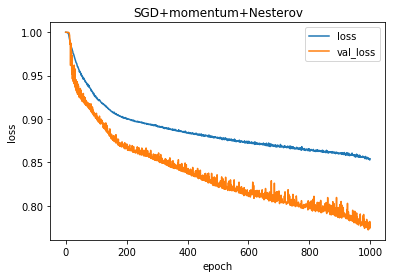

In [27]:
# print(np.array(history.losses))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('SGD+momentum+Nesterov')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# let's predict a TRAINING sammple:
decoded_train = autoencoder.predict(x_train)
decoded_test = autoencoder.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(272, 60, 800, 1)
(69, 60, 800, 1)


Training sample 0 : Correlation  [ 0.72512519]  P-value:  [ 0.]
Training sample 1 : Correlation  [ 0.69653434]  P-value:  [ 0.]
Training sample 2 : Correlation  [ 0.70283097]  P-value:  [ 0.]
Training sample 3 : Correlation  [ 0.66329432]  P-value:  [ 0.]
Training sample 4 : Correlation  [ 0.57558787]  P-value:  [ 0.]
Training sample 5 : Correlation  [ 0.58472562]  P-value:  [ 0.]
Training sample 6 : Correlation  [ 0.59666264]  P-value:  [ 0.]
Training sample 7 : Correlation  [ 0.61557615]  P-value:  [ 0.]
Training sample 8 : Correlation  [ 0.59532315]  P-value:  [ 0.]
Training sample 9 : Correlation  [ 0.60760808]  P-value:  [ 0.]
Training sample 10 : Correlation  [ 0.58613318]  P-value:  [ 0.]
Training sample 11 : Correlation  [ 0.68729746]  P-value:  [ 0.]
Training sample 12 : Correlation  [ 0.73285389]  P-value:  [ 0.]
Training sample 13 : Correlation  [ 0.6953128]  P-value:  [ 0.]
Training sample 14 : Correlation  [ 0.67321795]  P-value:  [ 0.]
Training sample 15 : Correlation  [ 

Training sample 215 : Correlation  [ 0.05555185]  P-value:  [ 0.11641396]
Training sample 216 : Correlation  [ 0.34147102]  P-value:  [  2.68994059e-23]
Training sample 217 : Correlation  [ 0.43255591]  P-value:  [  8.24623172e-38]
Training sample 218 : Correlation  [ 0.46124902]  P-value:  [  2.15799964e-43]
Training sample 219 : Correlation  [ 0.54922521]  P-value:  [ 0.]
Training sample 220 : Correlation  [ 0.57126719]  P-value:  [ 0.]
Training sample 221 : Correlation  [ 0.4697971]  P-value:  [  4.20389539e-45]
Training sample 222 : Correlation  [ 0.45577818]  P-value:  [  2.75215018e-42]
Training sample 223 : Correlation  [ 0.51641411]  P-value:  [ 0.]
Training sample 224 : Correlation  [ 0.56202596]  P-value:  [ 0.]
Training sample 225 : Correlation  [ 0.58367354]  P-value:  [ 0.]
Training sample 226 : Correlation  [ 0.61344767]  P-value:  [ 0.]
Training sample 227 : Correlation  [ 0.61795062]  P-value:  [ 0.]
Training sample 228 : Correlation  [ 0.62971103]  P-value:  [ 0.]
Trai

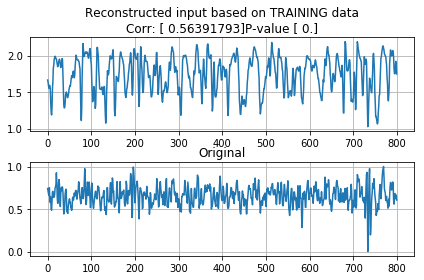

In [30]:
reconstruct_training_sample = True
chan = 13
samp = 180

from scipy.stats import pearsonr
# now let's see how the model performs:
r_accumulator = []

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
    orig = x_train[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_train.shape[0]):
        reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
        orig = x_train[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Training sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))
else:
    reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
    orig = x_test[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TESTING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_test.shape[0]):
        reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
        orig = x_test[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Test sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.set_title(title)
ax.grid()
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
plt.tight_layout()
ax.set_title("Original")
ax.grid()

Test sample 0 : Correlation  [ 0.47509801]  P-value:  [ 0.]
Test sample 1 : Correlation  [ 0.51149452]  P-value:  [ 0.]
Test sample 2 : Correlation  [ 0.49352029]  P-value:  [ 0.]
Test sample 3 : Correlation  [ 0.6073795]  P-value:  [ 0.]
Test sample 4 : Correlation  [ 0.59454221]  P-value:  [ 0.]
Test sample 5 : Correlation  [ 0.59018493]  P-value:  [ 0.]
Test sample 6 : Correlation  [ 0.55333585]  P-value:  [ 0.]
Test sample 7 : Correlation  [ 0.5507409]  P-value:  [ 0.]
Test sample 8 : Correlation  [ 0.55475879]  P-value:  [ 0.]
Test sample 9 : Correlation  [ 0.58399832]  P-value:  [ 0.]
Test sample 10 : Correlation  [ 0.57415867]  P-value:  [ 0.]
Test sample 11 : Correlation  [ 0.58130622]  P-value:  [ 0.]
Test sample 12 : Correlation  [ 0.56964087]  P-value:  [ 0.]
Test sample 13 : Correlation  [ 0.54215288]  P-value:  [ 0.]
Test sample 14 : Correlation  [ 0.53503907]  P-value:  [ 0.]
Test sample 15 : Correlation  [ 0.49753621]  P-value:  [ 0.]
Test sample 16 : Correlation  [ 0.49

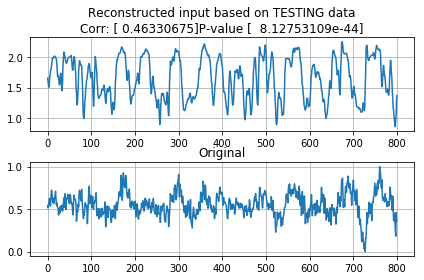

In [31]:
reconstruct_training_sample = False
chan = 13
samp = 36

from scipy.stats import pearsonr
# now let's see how the model performs:
r_accumulator = []

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
    orig = x_train[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_train.shape[0]):
        reconst = decoded_train[samp,chan,:,:].reshape(leng,1)
        orig = x_train[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Training sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))
else:
    reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
    orig = x_test[samp,chan,:,:].reshape(leng,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TESTING data" + "\n" + "Corr: " + str(R) + "P-value " + str(p)
    for samp in range(y_test.shape[0]):
        reconst = decoded_test[samp,chan,:,:].reshape(leng,1)
        orig = x_test[samp,chan,:,:].reshape(leng,1)
        R,p = pearsonr(reconst, orig)
        r_accumulator.append(R)
        print("Test sample", samp, ": Correlation ", R, " P-value: ", p)
    print('average correlation = ', np.mean(r_accumulator))


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.set_title(title)
ax.grid()
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
plt.tight_layout()
ax.set_title("Original")
ax.grid()